```{contents}
```
## **Timeout Node in LangGraph**

A **Timeout Node** in LangGraph is a control mechanism that **bounds the execution time of a node or a subgraph**, preventing runaway execution, infinite waiting on tools/LLMs, and resource exhaustion in production systems.

It is a **reliability primitive** used to enforce *temporal correctness* of workflows.

---

### **1. Why Timeouts Are Required**

LLM workflows involve:

| Risk               | Consequence       |
| ------------------ | ----------------- |
| Slow LLM responses | Increased latency |
| Stuck API calls    | Hanging workflows |
| Infinite cycles    | Cost explosion    |
| Network failures   | Dead executions   |
| External tools     | Unbounded waits   |

A timeout transforms **unbounded execution** into a **controlled failure**.

---

### **2. Timeout in LangGraph — Conceptual Model**

LangGraph enforces timeouts at the **node, subgraph, or entire graph level**.

```
[ Node Start ]
      |
      |----(execution > timeout)----> [ Timeout Triggered ]
      |
[ Normal Completion ]
```

Timeout is not a node in isolation; it is a **policy attached to execution**.

---

### **3. Where Timeouts Apply**

| Scope    | Description                      |
| -------- | -------------------------------- |
| Node     | Limits individual node execution |
| Subgraph | Bounds complex workflows         |
| Graph    | Hard ceiling on full execution   |
| Cycle    | Prevents infinite loops          |
| Tool     | Limits external calls            |

---

### **4. Implementing Timeouts**

### **A. Graph-Level Timeout**

```python
graph.invoke(input, config={
    "timeout": 30  # seconds
})
```

The entire workflow must complete within 30 seconds.

---

### **B. Node-Level Timeout**

```python
builder.add_node(
    "llm_call",
    llm_function,
    timeout=10
)
```

If `llm_function` exceeds 10 seconds, execution fails.

---

### **C. Timeout with Retry**

```python
builder.add_node(
    "tool_call",
    tool_fn,
    timeout=5,
    retry=3
)
```

Timeout triggers retry policy.

---

### **5. Timeout in Cyclic Graphs**

Timeouts are critical for loops.

```python
graph.invoke(
    input,
    config={"recursion_limit": 10, "timeout": 60}
)
```

| Protection      | Purpose              |
| --------------- | -------------------- |
| Recursion limit | Stops infinite loops |
| Timeout         | Stops slow loops     |

---

### **6. Handling Timeout Failures**

Timeout triggers an **exception path** that can be captured.

```python
def on_timeout(state):
    return {"status": "failed", "reason": "timeout"}

builder.add_node("timeout_handler", on_timeout)
```

---

### **7. Production Usage Patterns**

| Pattern              | Usage               |
| -------------------- | ------------------- |
| Soft Timeout         | Retry with backoff  |
| Hard Timeout         | Abort execution     |
| Graceful Degradation | Partial result      |
| Failover             | Switch models/tools |
| Human Interrupt      | Manual override     |

---

### **8. Timeout vs Other Controls**

| Control         | Purpose                    |
| --------------- | -------------------------- |
| Timeout         | Controls time              |
| Retry           | Controls reliability       |
| Circuit Breaker | Controls cascading failure |
| Recursion Limit | Controls loops             |
| Rate Limit      | Controls traffic           |

---

### **9. Best Practices**

* Always apply timeouts to **LLM calls**
* Always bound **tool executions**
* Combine with **retry + fallback**
* Use strict limits in **production**
* Log every timeout event

---

### **10. Mental Model**

> **Timeout = Safety valve of time**

Timeout Nodes convert unreliable external systems into predictable components.



### Demonstration

In [1]:
import time
from typing import TypedDict
from langgraph.graph import StateGraph, END

class State(TypedDict):
    query: str
    result: str
    status: str

def slow_call(state):
    time.sleep(8)  # simulate slow external system
    return {"result": f"Processed: {state['query']}"}

def timeout_handler(state):
    return {"status": "timeout", "result": "Fallback response"}




In [2]:
builder = StateGraph(State)

builder.add_node("worker", slow_call, timeout=3, retry=2)
builder.add_node("on_timeout", timeout_handler)

builder.set_entry_point("worker")
builder.add_edge("worker", END)

builder.add_conditional_edges(
    "worker",
    lambda state: "on_timeout" if state.get("status") == "timeout" else END,
    {
        "on_timeout": "on_timeout",
        END: END
    }
)

graph = builder.compile()


In [3]:
result = graph.invoke({"query": "Important task"})
print(result)


{'query': 'Important task', 'result': 'Processed: Important task'}


In [4]:
safe_result = graph.invoke(
    {"query": "Another task"},
    config={"timeout": 10, "recursion_limit": 5}
)


In [5]:
safe_result

{'query': 'Another task', 'result': 'Processed: Another task'}

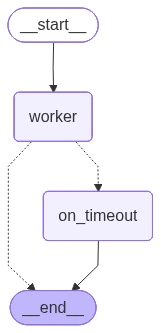

In [7]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))
